# Домашнее задание 3: Natural Language Inference
***
Анастасия Добрынина, БКЛ-211

In [ ]:
!pip install datasets transformers tokenizers -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModel

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Задача 1: 3 балла
Исследуем варьирование комитмента в зависимости от оператора (отрицания, условия, модального оператора, вопроса) и глагола (think, know, believe etc.). Работаем с дейтасетом английского CommmitmentBank.

Hofmann et al. 2023 исследовали варьирование комитмента в английском в зависимости от оператора (отрицания, условия, модального оператора, вопроса) и предиката и установили, что условный контекст более проективен (чаще сохраняет следствия), чем вопросительный, который, в свою очередь, более проективен, чем контекст отрицания и модального оператора, также они отметили варьирование по предикату. Ранее Sieker & Solstad 2022 установили, что для немецкого языка контекст отрицания -- самый проективный контекст.

Посчитайте средний рейтинг комитмента по предикату (think, know, believe etc.) и по оператору (modal, negation, conditional, question) из дейтасета, приведите релевантный код (1 балл) и постройте график (1 балл), аналогичный Figure 1 в Hofmann et al. 2023. Кратко прокомментируйте результат (1 балл): подтвердилась ли на нашем дейтасете гипотеза, что в английском условный контекст более проективен (чаще сохраняет следствия), чем вопросительный, который, в свою очередь, более проективен, чем контекст отрицания и модального оператора?

In [31]:
combank = pd.read_csv('CommitmentBank-items.csv')
combank.head()

,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,MatSubjPer,MatSubjNum,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,third,singular,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2"
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,third,singular,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1"
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,third,singular,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2"
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,third,singular,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2"
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,third,singular,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1"


Посчитаем среднее по оператору

In [49]:
pivot_emb = combank.loc[:,['Embedding', 'Mean']][(combank['Embedding'] == 'conditional') |
                                                 (combank['Embedding'] == 'modal') |
                                                 (combank['Embedding'] == 'negation') |
                                                 (combank['Embedding'] == 'question')].groupby(['Embedding'], dropna = False).agg(['mean'])['Mean']
pivot_emb

,mean
Embedding,
conditional,0.563778
modal,1.108415
negation,-0.671820
question,0.453370


Видим следующий рейтинг (от самого проективного, до самого непроективного контекста):
улсловные предложения > вопросительные предложкния > предложения с модальным оператором > отрицание

Это полностью соответствует находкам в Hofmann et al., более того, контраст между отрицанием и модальными операторами: отрицание крайне непроективно в английском (заставляет задуматься о таких противополжных свойствам проективности под отрицанием в английском и немецком)

In [50]:
pivot_verbs = combank.loc[:,['Verb', 'Mean']].groupby(['Verb'], dropna = False).agg(['mean'])['Mean']
pivot_verbs.sort_values(by = 'mean')

,mean
Verb,
occur,-1.500000
pretend,-1.483796
seem,-1.292929
guarantee,-1.005556
think,-1.002429
suggest,-0.738450
suppose,-0.630208
expect,-0.588235
demand,-0.583333


Низкие оценки получают глаголы в основном глаголы, выражающие неуверенность (или даже притворство): *pretend, seem, imagine*, и, напротив, выражающие уверенность: *guarantee*. Глагол *hypothesize* всегда получает нейтральную оценку: под любым оператором мы не можем быть уверены в верности или неверности гипотезы. Высокие оценки получают в основном фактивные глаглоы: *understand, realize* etc.

Визуализируем оба параметра

In [38]:
pivot = combank.loc[:,['Verb', 'Embedding', 'Mean']].groupby(['Verb', 'Embedding'], dropna = False).agg(['mean'])['Mean']
pivot.head(10)

mean
Verb     Embedding            
accept   negation     1.777778
         question     1.625000
admit    conditional  2.000000
         modal        1.754630
         negation    -0.222222
         question     0.555556
announce conditional  0.833333
         modal        1.333333
         question     0.777778
assume   conditional  0.666667

In [5]:
# привожу в более удобный вид
new_df = pd.DataFrame(pivot['mean'].items())
new_pivot = pd.DataFrame({'Verbs': new_df[0].apply(lambda x: x[0]),
                           'Embedding': new_df[0].apply(lambda x: x[1]),
                          'Mean': new_df[1]})

In [6]:
new_pivot.head()

,Verbs,Embedding,Mean
0,accept,negation,1.777778
1,accept,question,1.625000
2,admit,conditional,2.000000
3,admit,modal,1.754630
4,admit,negation,-0.222222


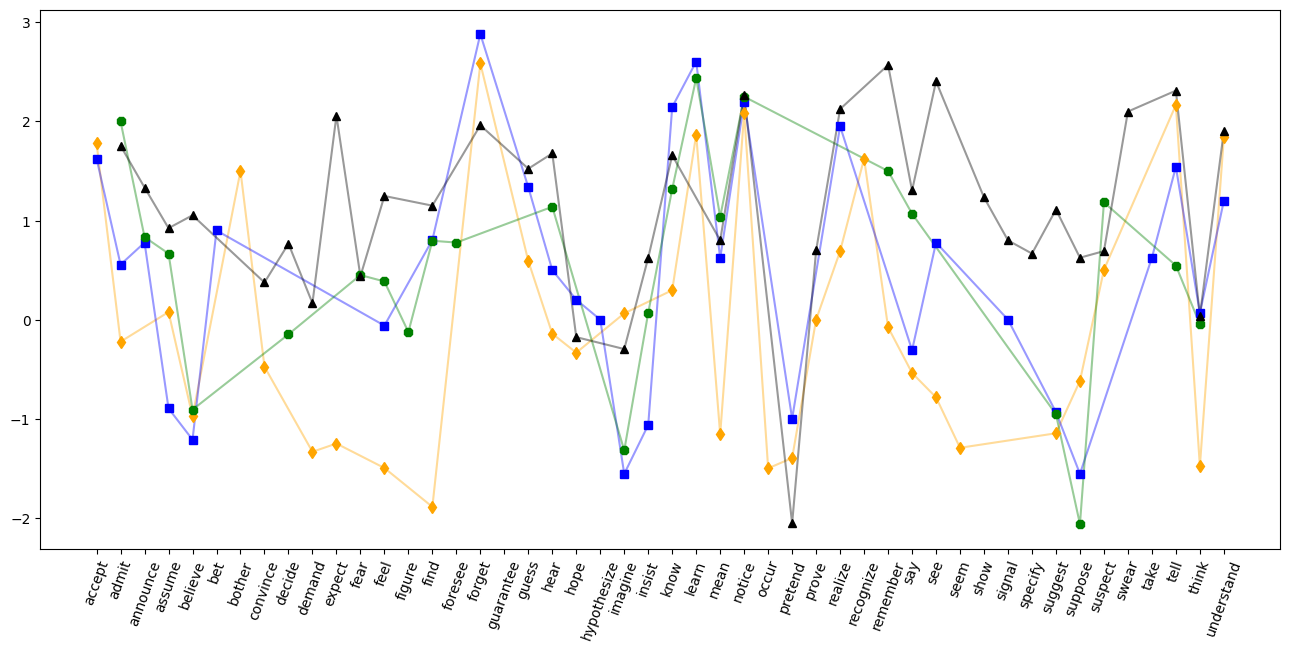

In [7]:
verbs = list(new_pivot['Verbs'].unique())
plt.figure(figsize = (16, 7))

plt.plot(verbs, [0]*48, alpha = 0) # чтобы все глаголы сразу были на оси

plt.plot(new_pivot[new_pivot['Embedding'] == 'negation']['Verbs'], new_pivot[new_pivot['Embedding'] == 'negation']['Mean'], 'orange',
         new_pivot[new_pivot['Embedding'] == 'question']['Verbs'], new_pivot[new_pivot['Embedding'] == 'question']['Mean'], 'blue',
         new_pivot[new_pivot['Embedding'] == 'conditional']['Verbs'], new_pivot[new_pivot['Embedding'] == 'conditional']['Mean'], 'green',
         new_pivot[new_pivot['Embedding'] == 'modal']['Verbs'], new_pivot[new_pivot['Embedding'] == 'modal']['Mean'], 'black',
         alpha = 0.4)

plt.plot(new_pivot[new_pivot['Embedding'] == 'negation']['Verbs'], new_pivot[new_pivot['Embedding'] == 'negation']['Mean'], 'd', c='orange')
plt.plot(new_pivot[new_pivot['Embedding'] == 'question']['Verbs'], new_pivot[new_pivot['Embedding'] == 'question']['Mean'], 's', c='blue')
plt.plot(new_pivot[new_pivot['Embedding'] == 'conditional']['Verbs'], new_pivot[new_pivot['Embedding'] == 'conditional']['Mean'], '8', c='green')
plt.plot(new_pivot[new_pivot['Embedding'] == 'modal']['Verbs'], new_pivot[new_pivot['Embedding'] == 'modal']['Mean'], '^', c='black')

plt.xticks(rotation=70)

plt.show()

График в общих чертах похож на соответствующий в Hofmann et al.

Относительно варьирования по предикатам по графику отчетливо видно, что есть такие, для которых оценки всегда стремятся в одну сторону:

*imagine, pretend* - все оценки в среднем ниже

*notice, forget* - все оценки сосредоточены практически в одной точке наверху,

*think* - почти одна точка посередине, кроме отрицания

# Задача 2: 3 балла
Создаем CommitmentBank для русского: приведите 3 стимула (по 1 баллу за стимул и комментарий к нему) и прокомментируйте рейтинг комитмента, который Вы ставите целевому предложению в каждом из стимулов, какие лингвистические факторы влияют, по Вашему мнению, на рейтинг в каждом случае?

Напоминаем, что стимул состоит из 1) источник (например, НКРЯ, VK); 2) предикат (например, сказать, знать, подозревать); 3) тип оператора (ничего/отрицание/условие/модальный оператор/вопрос); 4) одно/два предложения до целевого; 5) целевое предложение, содержащее предикат; 6) Ваш рейтинг комитмента (от -3 до +3).

Материалы английского CommmitmentBank, где можно подробнее прочитать про разметку.

|№  | источник | предикат | оператор | контекст | целевое предложение | рейтинг |
|---|----------|----------|----------|----------|----------|----------|
|1  |   НКРЯ   | сообщать   |  нет|Слухи, слухи, слухи... |Иностранные радиостанции сообщают, что болен Брежнев. | -1 |
|2  |  НКРЯ    | предполагать | модальный оператор|«Мы будем следить за ситуацией, ведь на многих направлениях порядка 70 процентов цены сервисов связи в роуминге — это оплата услуг зарубежных операторов, и она происходит в валюте», — говорит представитель МТС Алексей Меркутов.|Следовательно, можно предположить, что цены изменятся и у этого оператора.|0|
|3  | НКРЯ| знать  | отрицание  | Мы прибываем, как прибывает вода во время наводнения.| Паводок не знает, что он — стихийное бедствие.| -3 |
|4a|НКРЯ| подумать | отрицание | Ценность книги Вахтина, Головко и Швайтиера — в усилии увидеть «людей междумирья» такими, каковы они в собственной цельности их жизни |И не подумайте, что это усилие имеет узкоакадемическое значение, способное волновать лишь этнографов да антропологов.|-2|
|4b|мой пример| подумать | отрицание | Придя домой, я закрыл дверь на ключ |Я не подумал, что кто-то придет позже меня| 2|

(1) -  контекст задает предвзятость: слухам мы не верим, тем более иностранным радиостанциям, поэтому здесь *сообщать* не фактивен

(2) - на неоднознаючную оценку влияет не только наличие модального оператора, но и семнатика самого глагола в его сфере действия

(3) - *знать* - фактивный глагол, под отрицанием дает полное отсутсвие следствия

(4а, б) - возможно стоит учитывать больше факторов, чем предложено в задании. Напрмер в этой паре примеров, как кажется, наклонение глагола влияет на коммитмент

# Задача 3: 4 балла
Переделываем английский CommitmentBank в дейтасет для NLI и тестируем, насколько хорошо с помощью BERT можно предсказать наличие следствия, противоречия или нейтрального отношения на этом дейтасете.

Примерный алгоритм (можно делать по-другому, но тогда кратко поясните, что и почему Вы делаете):

приводим изначальный дейтасет к нужному виду: берем средний рейтинг для каждого стимула, средний рейтинг в интервале [1,3] -- следствие (entailment), [0] -- нейтральное отношение (neutral), в интервале [-3,-1] -- противоречие (contradiction), приведите код, который создает из изначального дейтасета файл, который Вы подаете на вход BERT (0,5 балла);

с помощью любой модели семейства BERT ([хендаут про BERT](https://github.com/dashapopova/CompSem2024/blob/main/compsem_bert_Nika_Zykova.ipynb)) предскажите лейбл отношения (entailment, neutral, contradiction) для пары Target+Prompt (подсказка: подумайте, как использовать [CLS] и [SEP]), приведите релевантный код и precision, recall, F1 (3 балла);

кратко прокомментируйте результат (0,5 балла).

Можно посмотреть, как аналогичная задача решалась [тут](https://github.com/dashapopova/CompSem2024/blob/main/NLI/de%20Marneffe_CommitmentBank%20for%20NLI.pdf).

In [8]:
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when i

In [9]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [10]:
device_cpu = torch.device("cpu")

In [11]:
model = model.to(device_cpu)

Переведем все средние оценки в числа: 1 - следование, 0 - нейтральное, -1 - противоречие. Оставим в датасете объединенные контекст, целевое предложение и гипотезу (Prompt), а также отдельно оценку. Также избавимся от пустых значений

In [12]:
combank_bert = combank.copy()

In [14]:
combank_bert['Mean'] = combank_bert['Mean'].apply(lambda x: 1 if round(x) > 0 else (0 if round(x) == 0 else -1))

In [15]:
combank_bert['Premise'] = combank_bert['Context'] + ' ' + combank_bert['Target']

In [16]:
combank_bert = combank_bert[['Premise', 'Prompt', 'Mean']]

In [17]:
combank_bert.head()

,Premise,Prompt,Mean
0,Polly had to think quickly. They were still cl...,Polly was not an experienced ocean sailor,1
1,"Nevertheless, life went on as it always does. ...",the Kiwi Keith and the Mackenzie houses had pr...,1
2,"He patted her hand. If he had chosen to, Thoma...",some time in the middle of the nineteenth cent...,1
3,She could see his distorted image in the slant...,it was for the children,1
4,"She glanced around the room, laying her hot fl...",it was all right,0


In [18]:
combank_bert['Premise'][1]

'Nevertheless, life went on as it always does. By the accidents of distance and dates of birth both the Kiwi Keith and the Mackenzie houses had been spared the effects of war and neither knew the pain of loss or the sadness of wounds in young bodies. Indeed it could be said that they had prospered.'

In [19]:
combank_bert_new = combank_bert.copy()

В начале последовательности посылка + гипотеза вставим [CLS] - это начало пары, которую можель будет анализировать. Между ними вставим [SEP] - так как именно связность эти двух текстов надо будет оценить

In [20]:
combank_bert_new['Input'] = '[CLS] ' + combank_bert_new['Premise'] + ' [SEP] ' + combank_bert_new['Prompt']

In [21]:
combank_bert_new = combank_bert_new.dropna()

In [22]:
combank_bert_new['Input'][0]

'[CLS] Polly had to think quickly. They were still close enough to shore for him to return her to the police if she admitted she was not an experienced ocean sailor. [SEP] Polly was not an experienced ocean sailor'

Векторизуем

In [23]:
def vectorize_dataset_and_return(data):
    res = []
    for batch in tqdm(data):
        toks = tokenizer(batch, padding='max_length', truncation=True, return_tensors='pt',
          max_length=64)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()})
        res.append(torch.mean(model_output.last_hidden_state, dim=1))
    res = torch.vstack(res)
    return res.detach().cpu().numpy()

In [24]:
vecs = vectorize_dataset_and_return(combank_bert_new['Input'])
vecs.shape

100%|██████████| 1198/1198 [06:12<00:00,  3.21it/s]


(1198, 768)

Разобъем на тест и трейн

In [25]:
x_train, x_test, y_train, y_test = train_test_split(vecs, combank_bert_new['Mean'], test_size=0.33, random_state=42)

Обучаем

In [26]:
clf = MLPClassifier(random_state=1, max_iter=300, verbose=1)
clf.fit(x_train, y_train)

Iteration 1, loss = 1.13172200
Iteration 2, loss = 1.03625493
Iteration 3, loss = 1.07888764
Iteration 4, loss = 1.01187830
Iteration 5, loss = 1.01041412
Iteration 6, loss = 0.97423217
Iteration 7, loss = 0.99185979
Iteration 8, loss = 0.97795324
Iteration 9, loss = 0.96837951
Iteration 10, loss = 0.96377763
Iteration 11, loss = 0.97479133
Iteration 12, loss = 0.97885181
Iteration 13, loss = 0.95865044
Iteration 14, loss = 1.04505341
Iteration 15, loss = 0.97232708
Iteration 16, loss = 1.00760863
Iteration 17, loss = 1.03915667
Iteration 18, loss = 0.96615761
Iteration 19, loss = 0.94428733
Iteration 20, loss = 0.92709114
Iteration 21, loss = 0.93348044
Iteration 22, loss = 0.95117046
Iteration 23, loss = 1.00663297
Iteration 24, loss = 0.93532576
Iteration 25, loss = 0.93438969
Iteration 26, loss = 0.93349850
Iteration 27, loss = 0.97887998
Iteration 28, loss = 0.91990437
Iteration 29, loss = 0.97061685
Iteration 30, loss = 0.91073395
Iteration 31, loss = 1.05291981
Iteration 32, los

MLPClassifier(max_iter=300, random_state=1, verbose=1)

Получаем результаты

In [27]:
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

In [28]:
crep = classification_report(y_train, train_pred)
print(crep)

              precision    recall  f1-score   support

          -1       0.57      0.83      0.67       305
           0       0.83      0.03      0.06       170
           1       0.65      0.70      0.67       327

    accuracy                           0.61       802
   macro avg       0.68      0.52      0.47       802
weighted avg       0.66      0.61      0.54       802



In [29]:
crep = classification_report(y_test, test_pred)
print(crep)

              precision    recall  f1-score   support

          -1       0.46      0.72      0.57       144
           0       0.50      0.01      0.02        91
           1       0.55      0.58      0.57       161

    accuracy                           0.50       396
   macro avg       0.51      0.44      0.38       396
weighted avg       0.51      0.50      0.44       396



Вывод:
В целом модель плохо справляется. Для нейтрального отношения очень маленькая полнота - возможно, нейтральное следствие "теряется" среди следования и противоречния (еще на этапе обучения). Самая большая полнота - для противоречия. Выявления противоречия уступают по точности следствиям, поэтому F-score у них примерно одинаковый

